<a href="https://colab.research.google.com/github/wahabtlais/hard_hat_detection/blob/main/hard_hat_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.5 MB/s eta 0:00:00


In [2]:
import kagglehub
import os
from IPython.display import Image, display

In [3]:
path = kagglehub.dataset_download("andrewmvd/hard-hat-detection")
print("Path to dataset files:", path)

100%|██████████| 1.22G/1.22G [00:17<00:00, 74.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/hard-hat-detection/versions/1


In [7]:
import os

print("First 10 annotation files:", os.listdir(annots_dir)[:10])
print("First 10 image files:", os.listdir(os.path.join(path, "images"))[:10])

First 10 annotation files: ['hard_hat_workers1892.xml', 'hard_hat_workers4102.xml', 'hard_hat_workers981.xml', 'hard_hat_workers1552.xml', 'hard_hat_workers2090.xml', 'hard_hat_workers4006.xml', 'hard_hat_workers1436.xml', 'hard_hat_workers781.xml', 'hard_hat_workers4029.xml', 'hard_hat_workers901.xml']
First 10 image files: ['hard_hat_workers173.png', 'hard_hat_workers163.png', 'hard_hat_workers963.png', 'hard_hat_workers4371.png', 'hard_hat_workers4887.png', 'hard_hat_workers744.png', 'hard_hat_workers1628.png', 'hard_hat_workers4959.png', 'hard_hat_workers2460.png', 'hard_hat_workers1667.png']


In [8]:
import glob
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

# Correct dataset paths
images_dir = os.path.join(path, "images")
annots_dir = os.path.join(path, "annotations")

# Grab all common image formats
all_images = []
for ext in ["*.jpg", "*.jpeg", "*.png"]:
    all_images.extend(glob.glob(os.path.join(images_dir, ext)))

all_annots = glob.glob(os.path.join(annots_dir, "*.xml"))

print("Found images:", len(all_images))
print("Found annotations:", len(all_annots))

# Classes (helmet vs head)
classes = {"head": 0, "helmet": 1}

# Create YOLO folder structure
base_path = "datasets/hardhat"
for folder in ["images/train", "images/val", "labels/train", "labels/val"]:
    os.makedirs(os.path.join(base_path, folder), exist_ok=True)

# Split dataset
train_imgs, val_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

def convert_voc_to_yolo(xml_file, label_file):
    """Convert Pascal VOC XML annotations to YOLO format"""
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find("size")
    w, h = int(size.find("width").text), int(size.find("height").text)

    with open(label_file, "w") as f:
        for obj in root.findall("object"):
            cls = obj.find("name").text
            if cls not in classes:
                continue  # skip 'person'
            cls_id = classes[cls]

            xmlbox = obj.find("bndbox")
            xmin = int(xmlbox.find("xmin").text)
            ymin = int(xmlbox.find("ymin").text)
            xmax = int(xmlbox.find("xmax").text)
            ymax = int(xmlbox.find("ymax").text)

            # Convert to YOLO format
            x_center = (xmin + xmax) / 2.0 / w
            y_center = (ymin + ymax) / 2.0 / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h

            f.write(f"{cls_id} {x_center} {y_center} {bw} {bh}\n")

def process_dataset(img_list, subset):
    for img_file in img_list:
        filename = os.path.basename(img_file)
        xml_file = os.path.join(annots_dir, filename.rsplit(".", 1)[0] + ".xml")
        label_file = os.path.join(base_path, f"labels/{subset}", filename.rsplit(".", 1)[0] + ".txt")

        # Convert annotations to YOLO format
        convert_voc_to_yolo(xml_file, label_file)

        # Copy image into correct folder
        shutil.copy(img_file, os.path.join(base_path, f"images/{subset}", filename))

# Process train & val sets
process_dataset(train_imgs, "train")
process_dataset(val_imgs, "val")

print("✅ Dataset prepared successfully!")
print("Train images:", len(train_imgs))
print("Val images:", len(val_imgs))


Found images: 5000
Found annotations: 5000
✅ Dataset prepared successfully!
Train images: 4000
Val images: 1000


In [9]:
yaml_content = f"""
train: {os.path.abspath(base_path)}/images/train
val: {os.path.abspath(base_path)}/images/val

nc: 2
names: ['head', 'helmet']
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

print(open("data.yaml").read())



train: /content/datasets/hardhat/images/train
val: /content/datasets/hardhat/images/val

nc: 2
names: ['head', 'helmet']



In [10]:
from ultralytics import YOLO

# Load pretrained YOLOv8 small model
model = YOLO("yolov8s.pt")

# Train
model.train(data="data.yaml", epochs=30, imgsz=640, batch=16)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Ultralytics 8.3.183 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fals

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 22        [15, 18, 21]  1   2116822  ultralytics.nn.modules.head.Detect           [2, [128, 256, 512]]          
Model summary: 129 layers, 11,136,374 parameters, 11,136,358 gradients, 28.6 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2343.3±691.8 MB/s, size: 286.1 KB)


train: Scanning /content/datasets/hardhat/labels/train... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:03<00:00, 1138.04it/s]


train: New cache created: /content/datasets/hardhat/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1705.5±1262.2 MB/s, size: 243.6 KB)


val: Scanning /content/datasets/hardhat/labels/val... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:02<00:00, 464.44it/s]


val: New cache created: /content/datasets/hardhat/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.69G      1.474      1.274      1.217        110        640: 100%|██████████| 250/250 [01:37<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]


                   all       1000       4825      0.861      0.731      0.842      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.49G      1.423     0.9362      1.185        132        640: 100%|██████████| 250/250 [01:32<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


                   all       1000       4825      0.566      0.738      0.532      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.52G       1.41       0.91      1.177        104        640: 100%|██████████| 250/250 [01:31<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


                   all       1000       4825      0.854      0.724      0.827      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.56G      1.407      0.909      1.181        112        640: 100%|██████████| 250/250 [01:31<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


                   all       1000       4825      0.857      0.799      0.864      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       4.6G      1.367     0.8565      1.163        163        640: 100%|██████████| 250/250 [01:30<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


                   all       1000       4825      0.878      0.812      0.897      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.63G      1.352     0.8123      1.153         94        640: 100%|██████████| 250/250 [01:31<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


                   all       1000       4825      0.881      0.837      0.902      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.67G      1.337     0.8024      1.145        124        640: 100%|██████████| 250/250 [01:30<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


                   all       1000       4825      0.889      0.833      0.899      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30       4.7G      1.325     0.7705      1.146        134        640: 100%|██████████| 250/250 [01:30<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


                   all       1000       4825      0.911      0.835      0.916      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.74G      1.315     0.7438      1.131        133        640: 100%|██████████| 250/250 [01:30<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


                   all       1000       4825      0.903      0.839      0.907      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.78G      1.302     0.7356      1.128         97        640: 100%|██████████| 250/250 [01:29<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]

                   all       1000       4825      0.903      0.855      0.921       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.81G       1.29     0.7138      1.118        122        640: 100%|██████████| 250/250 [01:30<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


                   all       1000       4825      0.901       0.86      0.924      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.85G      1.284     0.7129      1.117        116        640: 100%|██████████| 250/250 [01:31<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]


                   all       1000       4825      0.921      0.853      0.923      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.88G      1.264     0.6804      1.112        123        640: 100%|██████████| 250/250 [01:30<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


                   all       1000       4825       0.92       0.87      0.933      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.92G      1.261     0.6763      1.104        152        640: 100%|██████████| 250/250 [01:29<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


                   all       1000       4825      0.914      0.871      0.931      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.96G      1.242      0.662      1.097         68        640: 100%|██████████| 250/250 [01:30<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


                   all       1000       4825      0.906      0.883      0.937       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.99G      1.242     0.6641      1.099        102        640: 100%|██████████| 250/250 [01:31<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


                   all       1000       4825      0.915      0.878      0.937      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.03G      1.233     0.6456       1.09        174        640: 100%|██████████| 250/250 [01:31<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


                   all       1000       4825      0.916      0.883      0.942       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.07G      1.216     0.6285      1.087        114        640: 100%|██████████| 250/250 [01:30<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


                   all       1000       4825      0.921      0.882      0.939      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30       5.1G      1.207     0.6176      1.079        119        640: 100%|██████████| 250/250 [01:30<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


                   all       1000       4825      0.909      0.895      0.942      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.14G      1.205     0.6181      1.075        123        640: 100%|██████████| 250/250 [01:30<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


                   all       1000       4825      0.929      0.889      0.943      0.617
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.18G      1.198     0.5499      1.093         75        640: 100%|██████████| 250/250 [01:29<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]


                   all       1000       4825      0.931      0.884      0.944      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.21G      1.188     0.5434      1.089         72        640: 100%|██████████| 250/250 [01:26<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]

                   all       1000       4825      0.924      0.889      0.944      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.25G      1.181     0.5333      1.083         90        640: 100%|██████████| 250/250 [01:26<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]

                   all       1000       4825      0.932      0.893      0.949      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.29G      1.162     0.5204      1.078         73        640: 100%|██████████| 250/250 [01:25<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]

                   all       1000       4825      0.912      0.901      0.949      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.32G      1.155     0.5099      1.068         44        640: 100%|██████████| 250/250 [01:26<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


                   all       1000       4825      0.931      0.887      0.944      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.36G      1.142     0.5018       1.07         55        640: 100%|██████████| 250/250 [01:26<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]

                   all       1000       4825      0.936      0.885      0.951      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.39G      1.136     0.4926      1.062         89        640: 100%|██████████| 250/250 [01:26<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]

                   all       1000       4825      0.934      0.899      0.951      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.43G       1.12     0.4815      1.057         61        640: 100%|██████████| 250/250 [01:28<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


                   all       1000       4825      0.936      0.895      0.951       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.47G      1.111     0.4716       1.05         76        640: 100%|██████████| 250/250 [01:28<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


                   all       1000       4825      0.926      0.899      0.947      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30       5.5G      1.099      0.465      1.044         53        640: 100%|██████████| 250/250 [01:27<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]

                   all       1000       4825      0.926      0.904      0.948      0.639



30 epochs completed in 0.864 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.183 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]


                   all       1000       4825      0.936      0.896      0.951       0.64
                  head        186       1106      0.919      0.876      0.931      0.625
                helmet        913       3719      0.952      0.915       0.97      0.655
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ed3fc3503e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

Ultralytics 8.3.183 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3351.4±628.6 MB/s, size: 227.2 KB)


val: Scanning /content/datasets/hardhat/labels/val.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]


                   all       1000       4825      0.935      0.895       0.95      0.641
                  head        186       1106      0.918      0.876      0.931      0.626
                helmet        913       3719      0.951      0.915       0.97      0.656
Speed: 0.9ms preprocess, 9.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train4
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ed3fc360dd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,    

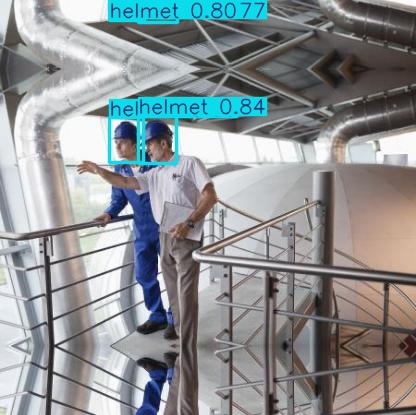

In [12]:
# Validate model on validation set
metrics = model.val()
print(metrics)

# Test inference on validation images
results = model.predict(source=f"{base_path}/images/val", save=True, conf=0.25)


# Get the folder where predictions were saved
save_dir = results[0].save_dir

# Pick one of the saved files
pred_file = os.path.join(save_dir, os.listdir(save_dir)[0])

# Display it
display(Image(filename=pred_file))
